# New York Airbnb EDA solution
**Possible questions to answer:**
* availability_365:
    * What could affect the accomodation demand?
* calculated_host_listings_count:
    * More offer equals to more rentals of the same accomodation?
* number_of_reviews:
    * More reviews equals more rentals?
* minimum_nights:
    * More flexible minimum nights equals more rentals?

According to the article published by [Tech Crunch](https://techcrunch.com/2023/05/03/airbnbs-average-home-prices-have-gone-up-so-now-its-refocusing-on-rooms-to-give-users-more-affordable-alternatives/) published May 23, 2023 and others like [ThePointsGuy](https://thepointsguy.com/news/airbnb-rate-surge/), at that specific point in time we were seeing a 36% increase on Airbnb rental prices in contrast with 2019.

With this, even before starting our analysis, we can assume that if prices are below the current cheapest accomodation in 2024 minus the 36% price increase is either misinformation or "trash" data.

By doing a quick research on the actual (Airbnb)[www.airbnb.mx] site I concluded that the cheapest accomodations are between **30 USD** and **40 USD** at this time, so substracting the 36% increase we get that the (possible) minimum price per night at that time was **18.56 USD**

In [224]:
# General Libraries
import warnings

# Data Analysis & Visualization
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split

In [225]:
warnings.filterwarnings("ignore")

In [226]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv'
df = pd.read_csv(url)
df.to_csv('../data/raw/AB_NYC_2019.csv', index = False)

In [227]:
df = pd.read_csv('../data/raw/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [228]:
print(
    'COLUMNS:\n ', df.columns, '\n', '\n',
    'DTYPES:\n', df.dtypes, '\n', '\n',
    'SHAPE: \n', '\tRows: ', df.shape[0], '\n\tColumns: ', df.shape[1]
)

COLUMNS:
  Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object') 
 
 DTYPES:
 id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                  

In [229]:
columns_to_drop = ['id','host_name', 'latitude', 'longitude','last_review', 'reviews_per_month']
df = df.drop(columns=columns_to_drop, axis=1)

In [230]:
df.drop(df[df['price'] < 20].index, inplace=True)

In [231]:
cols = df.columns

for nulos in cols:
    if nulos == 'price':
        print(f'{nulos} has {df.price[df[nulos] < 19].sum()} lower than 19 USD\n')
    if df[nulos].isna().sum() > 0:
        print(f'{nulos}: {df[nulos].isna().sum()}')
    else:
        print(f'No NA values in column: {nulos}')

name: 16
No NA values in column: host_id
No NA values in column: neighbourhood_group
No NA values in column: neighbourhood
No NA values in column: room_type
price has 0 lower than 19 USD

No NA values in column: price
No NA values in column: minimum_nights
No NA values in column: number_of_reviews
No NA values in column: calculated_host_listings_count
No NA values in column: availability_365


In [232]:
for u in df.columns:
    print(f'{u}: {len(df[u].unique())}')

df.shape

name: 47855
host_id: 37425
neighbourhood_group: 5
neighbourhood: 221
room_type: 3
price: 665
minimum_nights: 109
number_of_reviews: 394
calculated_host_listings_count: 47
availability_365: 366


(48841, 10)

### Univariate Variables

##### Categorical Variables

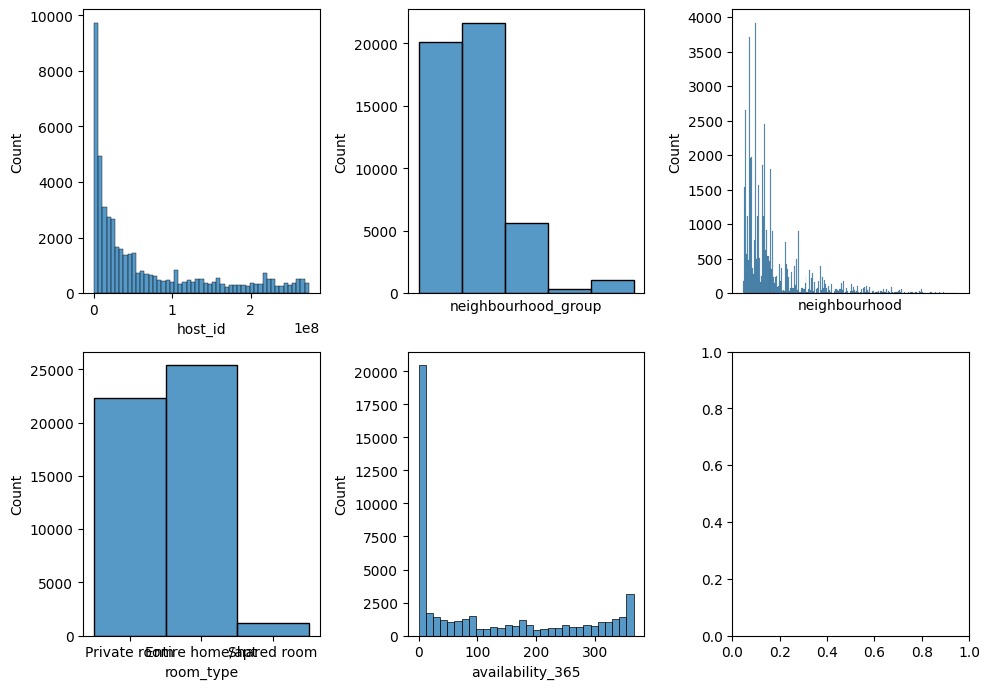

In [233]:
fig, axis = plt.subplots(2, 3, figsize = (10, 7))

sns.histplot(ax=axis[0,0], data = df, x = 'host_id')
sns.histplot(ax=axis[0,1], data = df, x = 'neighbourhood_group').set_xticks([])
sns.histplot(ax=axis[0,2], data = df, x = 'neighbourhood').set_xticks([])
sns.histplot(ax=axis[1,0], data = df, x = 'room_type')
sns.histplot(ax=axis[1,1], data = df, x = 'availability_365')

plt.tight_layout()

plt.show()

##### Numeric Variables

In [234]:
print('Total Accomodations over 1K USD per night:', df[df['price'] > 1000].shape[0])
print('\t0 day Availability: ', df[(df['price'] > 1000) & (df['availability_365'] < 1)].shape[0])
print('\tApparently not booked: ', df[(df['price'] > 1000) & (df['availability_365'] > 364)].shape[0])

print('\nTotal Accomodations over 2K USD per night:', df[df['price'] > 2000].shape[0])
print('\t0 day Availability: ', df[(df['price'] > 2000) & (df['availability_365'] < 1)].shape[0])
print('\tApparently not booked: ', df[(df['price'] > 2000) & (df['availability_365'] > 364)].shape[0])

print(
    '\nTotal Accomodations between 1K and 4K a night: ', df[(df['price'] > 1000) & (df['price'] < 4000)].shape[0], '\n',
    '\tNot Available: ', df[(df['price'] > 1000) & (df['price'] < 4000) & (df['availability_365'] < 1)].shape[0], '\n',
    '\tAvailable: ', df[(df['price'] > 1000) & (df['price'] < 4000) & (df['availability_365'] > 1)].shape[0]
)

print(f'\n{round((204 * 100)/239)}% of the accomodations over 1K are less than 4K which means only 25% of the total accomodations are over 4K')

Total Accomodations over 1K USD per night: 239
	0 day Availability:  67
	Apparently not booked:  38

Total Accomodations over 2K USD per night: 86
	0 day Availability:  16
	Apparently not booked:  12

Total Accomodations between 1K and 4K a night:  204 
 	Not Available:  58 
 	Available:  146

85% of the accomodations over 1K are less than 4K which means only 25% of the total accomodations are over 4K


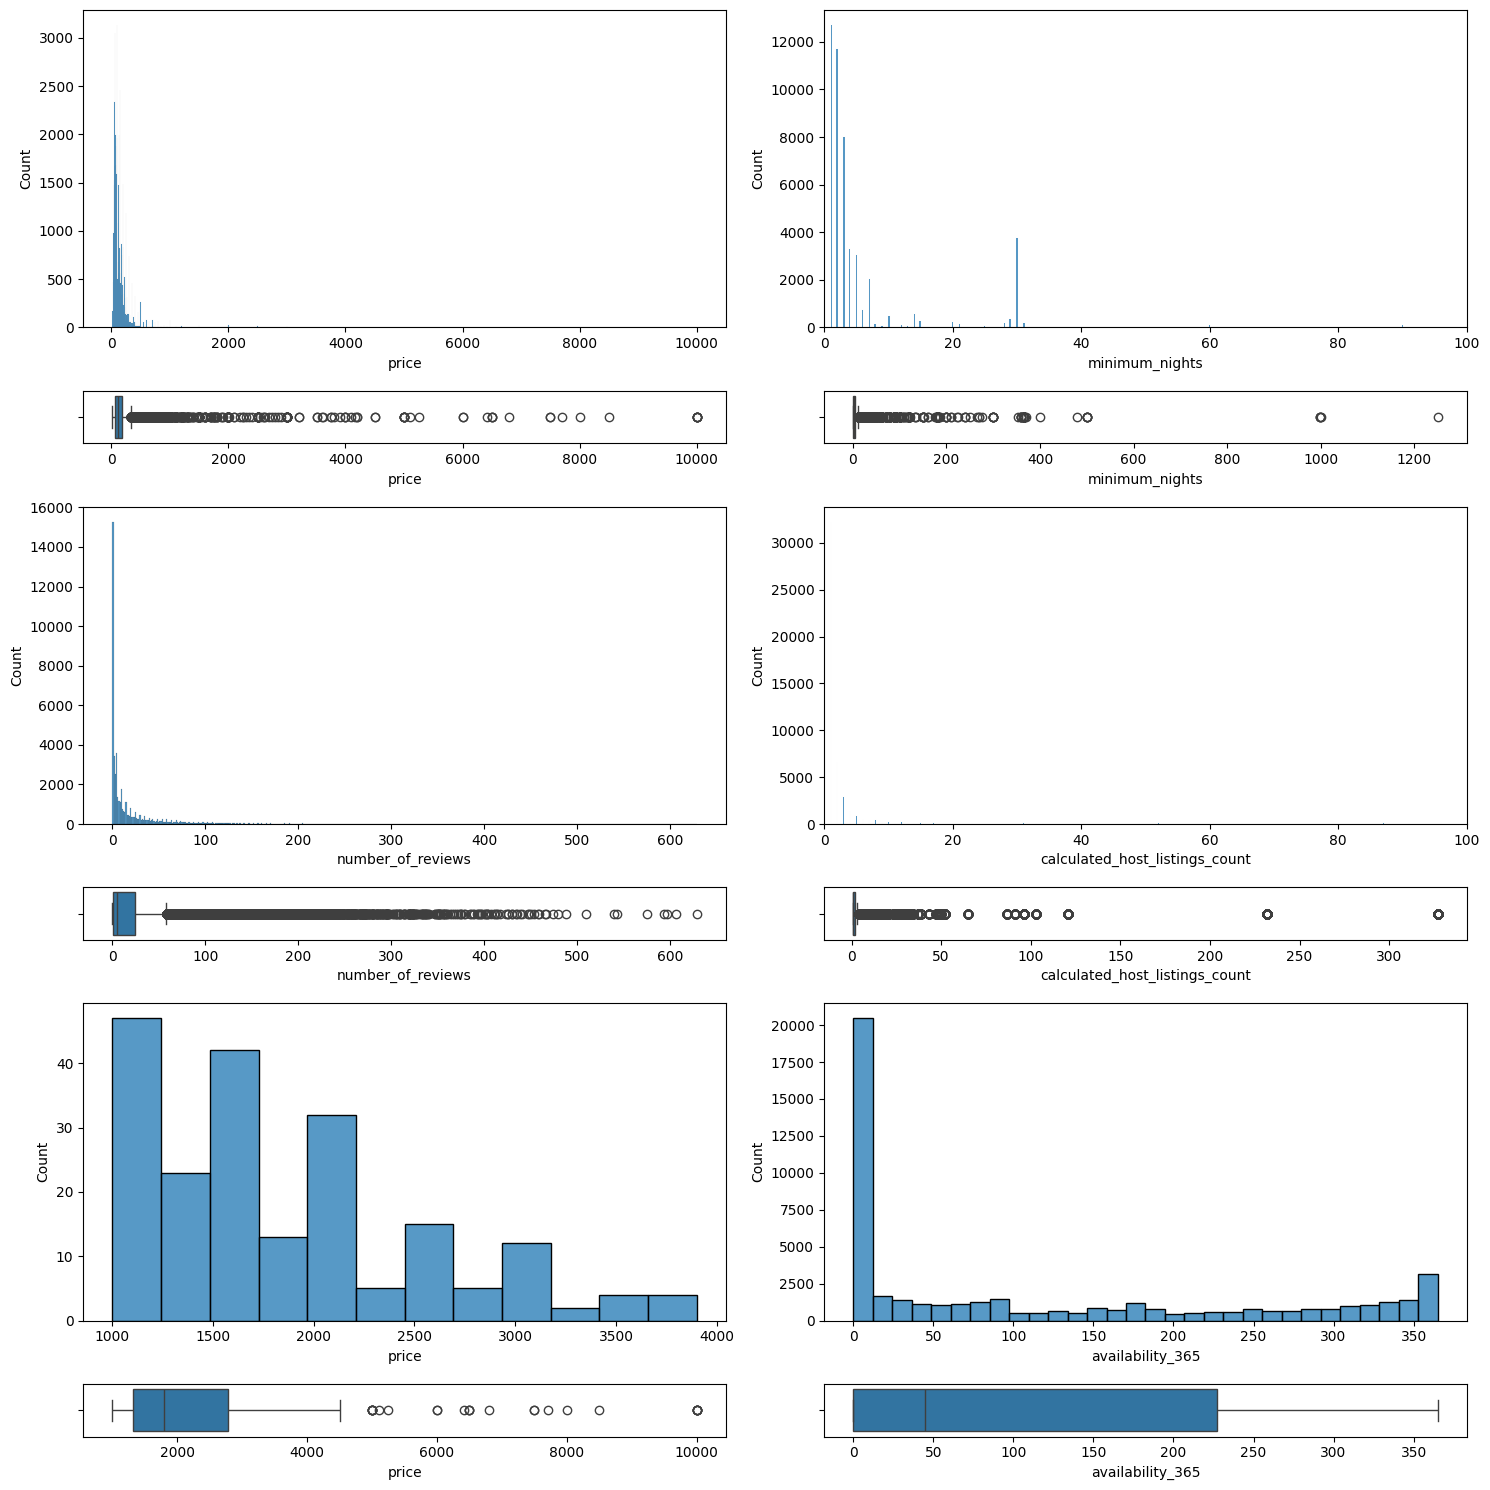

In [235]:
fig, axis = plt.subplots(
    nrows = 6,
    ncols = 2, 
    figsize = (
        15, 
        15
    ), 
    gridspec_kw = {
        "height_ratios": [6, 1, 6, 1, 6, 1]
    }
)

sns.histplot(ax = axis[0,0], data = df, x = 'price')
sns.boxplot(ax = axis[1,0], data = df, x = 'price')

sns.histplot(ax= axis[0,1], data = df, x = 'minimum_nights').set_xlim(0,100)
sns.boxplot(ax = axis[1,1], data = df, x = 'minimum_nights')

sns.histplot(ax = axis[2, 0], data = df, x = "number_of_reviews")
sns.boxplot(ax = axis[3, 0], data = df, x = "number_of_reviews")

sns.histplot(ax = axis[2,1], data = df, x = "calculated_host_listings_count").set_xlim(0,100)
sns.boxplot(ax = axis[3, 1], data = df, x = "calculated_host_listings_count")

sns.histplot(ax = axis[4,0], data = df[(df['price'] > 1000) & (df['price'] < 4000)], x = "price")
sns.boxplot(ax = axis[5,0], data = df[df['price'] > 1000], x = 'price')

sns.histplot(ax=axis[4,1], data = df, x = 'availability_365')
sns.boxplot(ax=axis[5,1], data = df, x = 'availability_365')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


#### Most Expensive Accomodations per night (Over 1K and 2K)

* We have 239 accomodations listed over 1K USD per night, 67 of them may be booked for the whole year or simply not available, 38 not booked
* We have 86 accomodations listed over 2K USD per night, 16 of them may be booked for the whole year or simply not available, 12 are not booked
* 85% of the accomodations over 1K are less than 4K which means only 25% of the total accomodations are over 4K

**With this information I cannot say accomodations with prices over 1K or even above 4K to be outliers to be remove as I dim possible to be information that could give us more insight into the price prediction process**


 Index(['name', 'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'availability_365'],
      dtype='object')

Minimum Nights:
	Minimum: 1 
	Maximum: 365

Number of Reviews:
	Minimum: 0 
	Maximum: 480


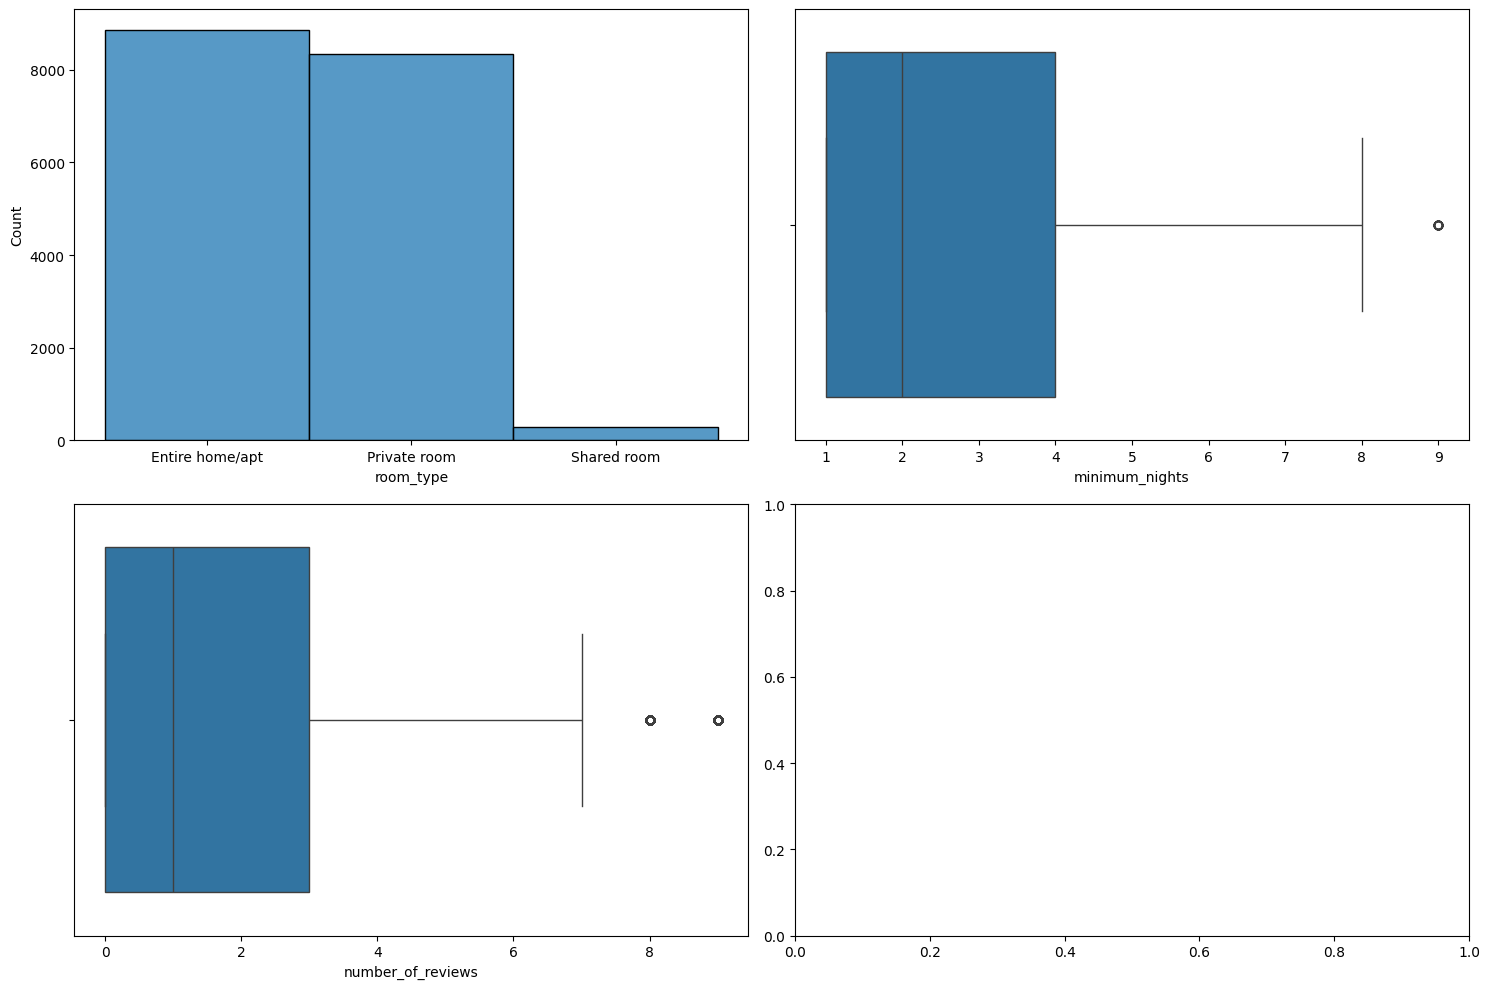

In [236]:
room_0_av = df[df['availability_365'] == 0]
room_0_av.drop(columns=['host_id', 'neighbourhood_group', 'neighbourhood','calculated_host_listings_count'], axis=1, inplace=True)

print('\n',room_0_av.columns)
print('\nMinimum Nights:\n\tMinimum:', room_0_av['minimum_nights'].min(), '\n\tMaximum:', room_0_av['minimum_nights'].max())
print('\nNumber of Reviews:\n\tMinimum:', room_0_av['number_of_reviews'].min(), '\n\tMaximum:', room_0_av['number_of_reviews'].max())


fig, axis = plt.subplots(nrows=2, ncols=2, figsize = (15, 10))

sns.histplot(ax = axis[0,0], data = room_0_av.sort_values(by = 'room_type'), x = 'room_type')
sns.boxplot(ax = axis[0,1], data = room_0_av[room_0_av['minimum_nights']<10], x="minimum_nights")
sns.boxplot(ax = axis[1,0], data = room_0_av[room_0_av['number_of_reviews']<10], x="number_of_reviews")

plt.tight_layout()
plt.show()

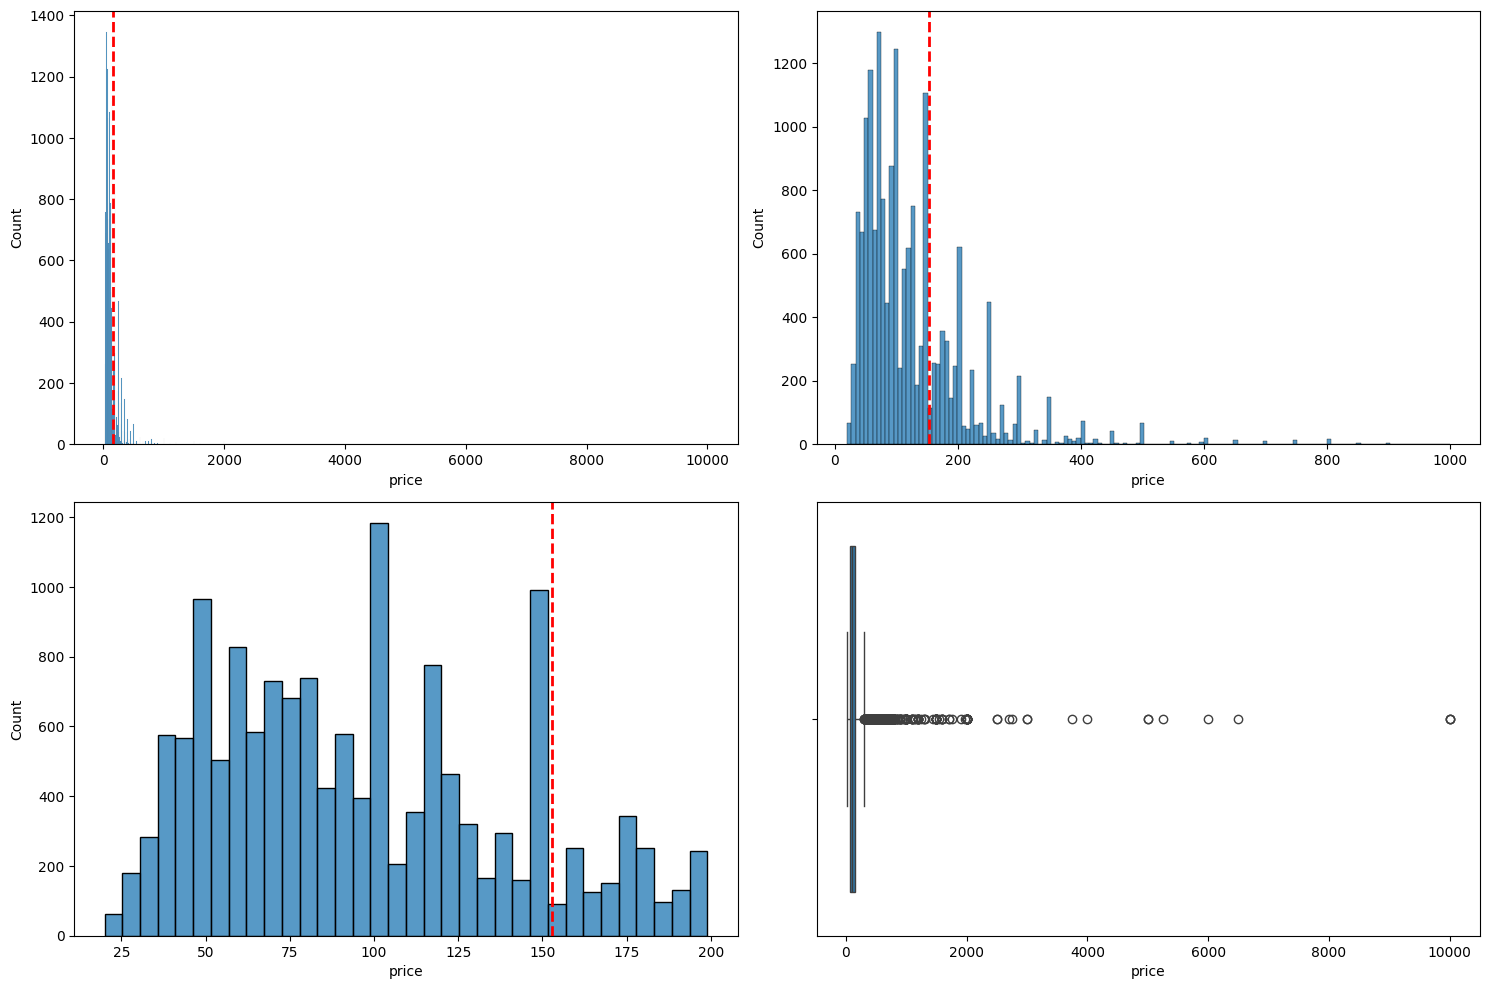

In [237]:
fig, axis = plt.subplots(2, 2, figsize=(15, 10))

mean_price = df['price'].mean()

sns.histplot(ax = axis[0,0], data = room_0_av, x="price")
sns.histplot(ax = axis[0,1], data = room_0_av[room_0_av['price']<1000], x="price")
sns.histplot(ax = axis[1,0], data = room_0_av[room_0_av['price']<200], x="price")
sns.boxplot(ax = axis[1,1], data = room_0_av, x="price")

axis[0, 0].axvline(x=mean_price, color='red', linestyle='dashed', linewidth=2, label=f'Mean Price: ${mean_price:.2f}')
axis[0, 1].axvline(x=mean_price, color='red', linestyle='dashed', linewidth=2, label=f'Mean Price: ${mean_price:.2f}')
axis[1, 0].axvline(x=mean_price, color='red', linestyle='dashed', linewidth=2, label=f'Mean Price: ${mean_price:.2f}')


plt.tight_layout()
plt.show()

#### When **availability_365** is equal to 0:
* Entire home/apt is the room_type with more rows at 0, followed by Private Room and finally with a big difference Shared Room, so I assume that according to the purpose of Airbnb those accomodations are booked for long-term living purposes
* Entire home/apt could be used for more than one person, maybe entire families
* Private Room and Shared Room may be used for people either travelling for a short period of time and the accomodations being on high demand as NY is a great place for tourism or may be used for medium-long term stays for either students, low income clients or users looking to save money

* The highest demand regarding prices is between the 50 USD and 150 USD
* The accomodations that are a little cheaper than the mean value(~160 USD) of the whole dataset are the 3rd most accomodations with 0 availability, so the most booked according to my first assumtion of the real interpretation of the availability column data
* The most booked accomodations are ~50 USD less than mean value price of the whole dataset

### Multivariate Variables
##### num - num

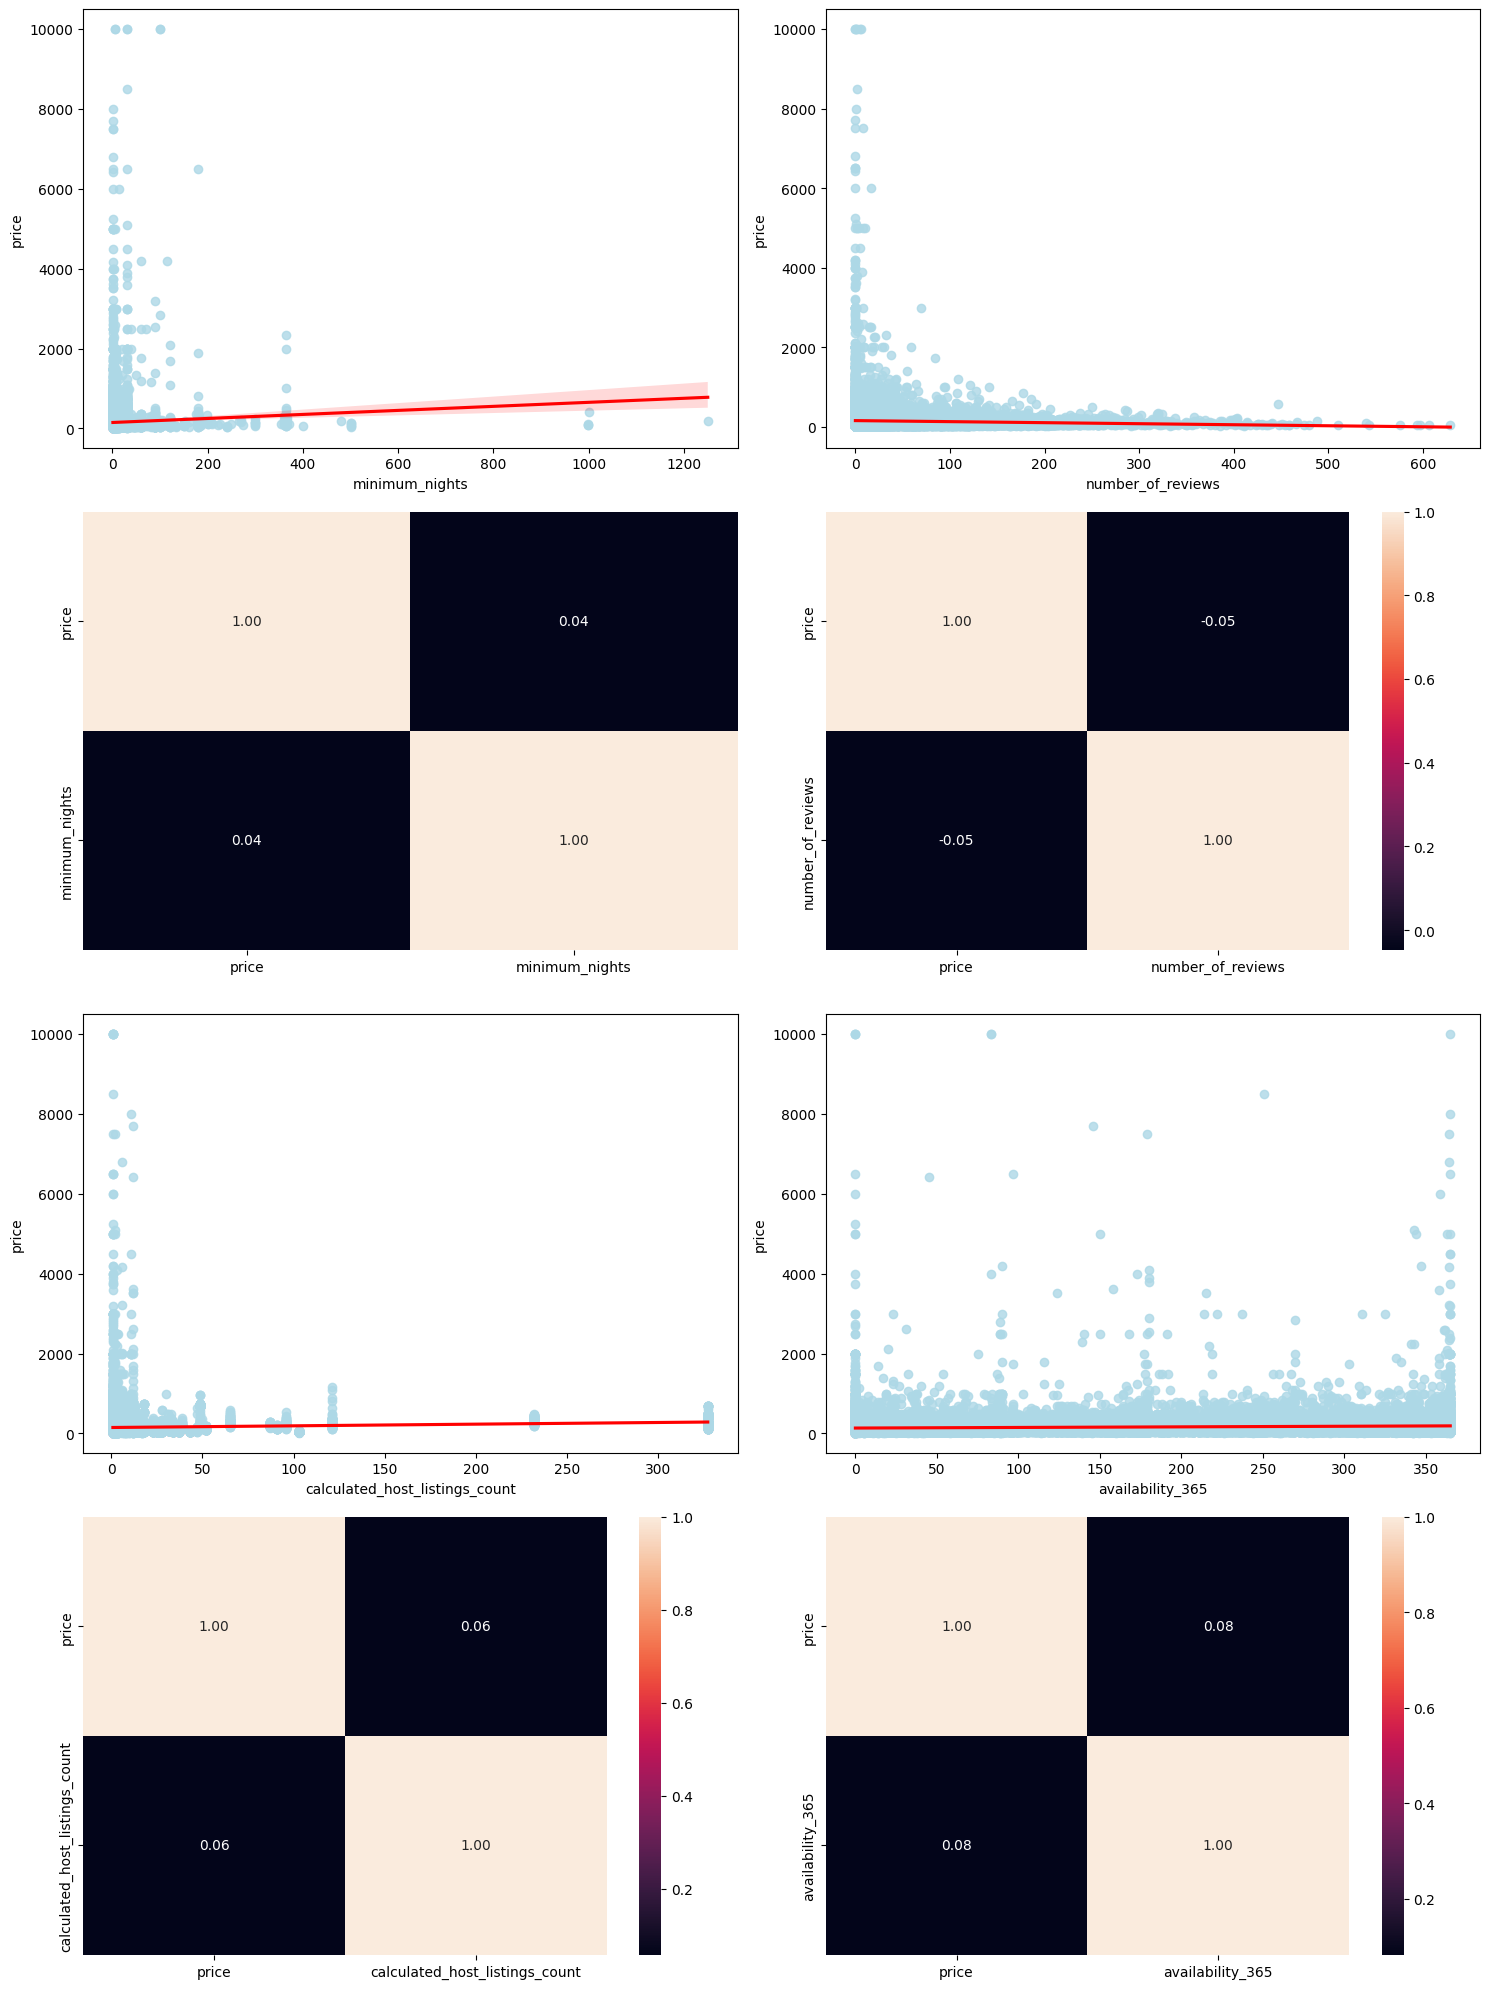

In [238]:
fig, axis = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
x_color = 'lightblue'
y_color = 'red'

sns.regplot(ax=axis[0,0], data = df, x = "minimum_nights", y = "price", scatter_kws={'color': x_color}, line_kws={'color': y_color})
sns.heatmap(df[["price", 'minimum_nights']].corr(), annot = True, fmt = ".2f", ax=axis[1,0], cbar = False)

sns.regplot(ax = axis[0, 1], data = df, x = "number_of_reviews", y = "price", scatter_kws={'color': x_color}, line_kws={'color': y_color})
sns.heatmap(df[["price", "number_of_reviews"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

sns.regplot(ax = axis[2,0], data = df, x = "calculated_host_listings_count", y = "price", scatter_kws={'color': x_color}, line_kws={'color': y_color})
sns.heatmap(df[["price", "calculated_host_listings_count"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0])

sns.regplot(ax = axis[2,1], data = df, x = "availability_365", y = "price", scatter_kws={'color': x_color}, line_kws={'color': y_color})
sns.heatmap(df[["price", "availability_365"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

* There's no clear relation between non of the variables

Cat-cat

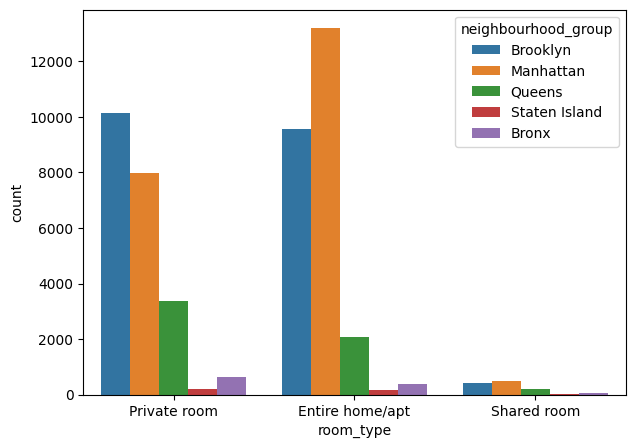

In [239]:
fig, axis = plt.subplots(figsize = (7, 5))

sns.countplot(data = df, x = "room_type", hue = "neighbourhood_group")

plt.show()

Manhattan -> 59.1 km² | Brooklyn -> 180 km² | Queens -> 280 km² | Staten Island -> 152 km² | Bronx -> 110 km²

* By Room Type we have:
    * Entire home/apt (Most Offers)
        * **Most:** Manhattan
        * **Less:** Staten Island

    * Private Room
        * **Most:** Brooklyn
        * **Less:** Staten Island 

    * Shared Room (Less Offers)
        * **Most:** Manhattan
        * **Less:** Staten Island


* Staten Island has significantly less accomodations than the other neighbourhood groups, we can assume that is related to the fact that is pretty much outside of the city and the transportation to the tourist places may be an issue since there are only 2 entrances to Staten Island from the may zones. Staten Island tends to be more of a residential zone.
* Bronx is a close second to Staten Island, maybe because of the high crime rate
* Queens in 3rd place is one of the safest zones to live in NYC according to the crime rates, on the other hand is far from Downtown and tourist places, the transportation costs might be a factor to be low demand and therefore low offer
* As for Manhattan and Brooklyn, as those are two of the most known Neighbourhood Groups in NYC we can assume that plays a primary role regarding the offer and demand, as well as the fact that Manhattan is the most tourist area in NYC and Brooklyn is just next to it.


* At first glance there's no relation between neighbourhood_group and room_type, to determine if there is an actual relation we would have to take a deep dive into the city infrastructure and the social aspects related to those zones.
    * At least from pop culture I can assume that Manhattan being an overcrowded city with lots of tower buildings and homes/apartments tend to be small and pricey, I can assume that Entire home/apt tends to be more present as the majority of them don't really have space to have more than 1 or 2 rooms, therefore they may have to be listed in that room type as is the whole place for the person or people who rent them

In [240]:
df['room_type'] = pd.factorize(df['room_type'])[0]
df['neighbourhood'] = pd.factorize(df['neighbourhood'])[0]
df['neighbourhood_group'] = pd.factorize(df['neighbourhood_group'])[0]

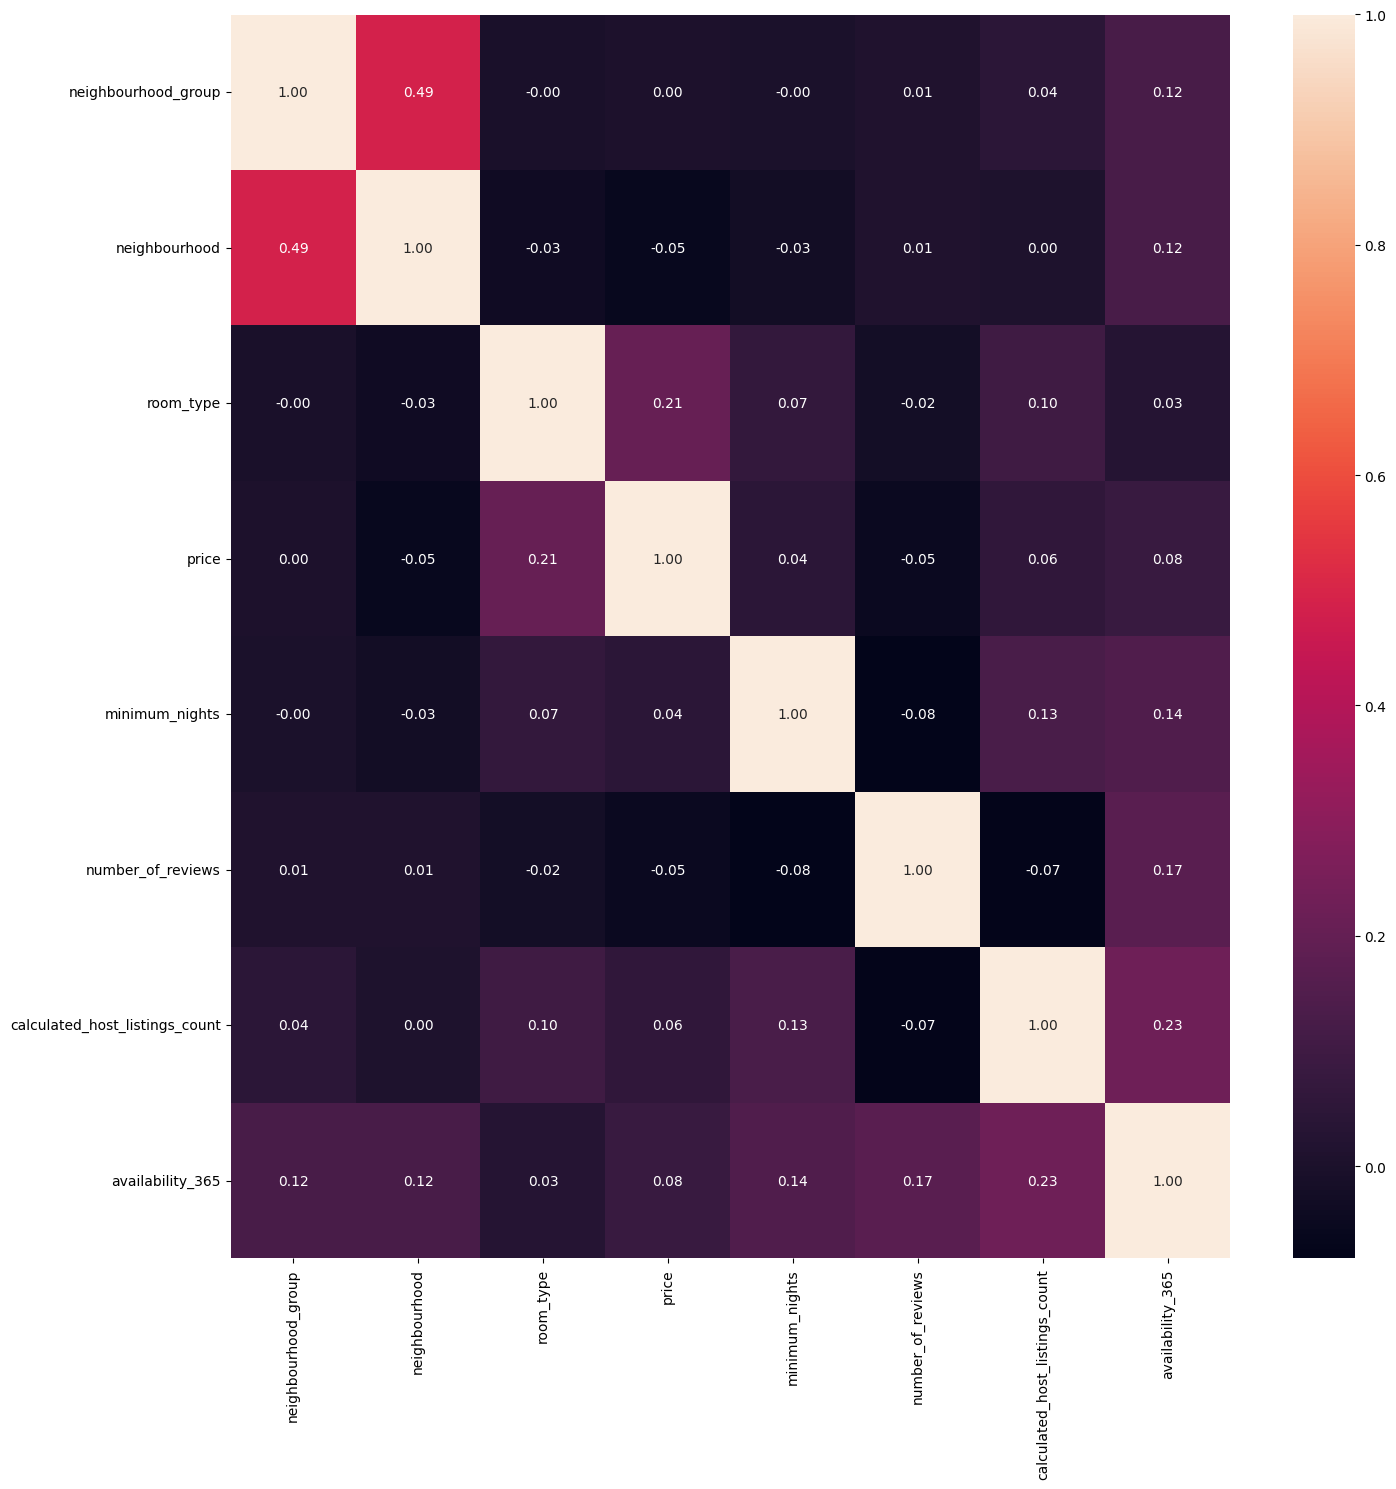

In [241]:
fig, axis = plt.subplots(figsize=(15,15))

sns.heatmap(
    df[
        [
            "neighbourhood_group",
            "neighbourhood",
            "room_type",
            "price",
            "minimum_nights",
            "number_of_reviews",
            "calculated_host_listings_count",
            "availability_365"
        ]
    ].corr(),
            annot = True, 
            fmt = ".2f"
)

plt.tight_layout()

# Draw Plot
plt.show()


#### All Data

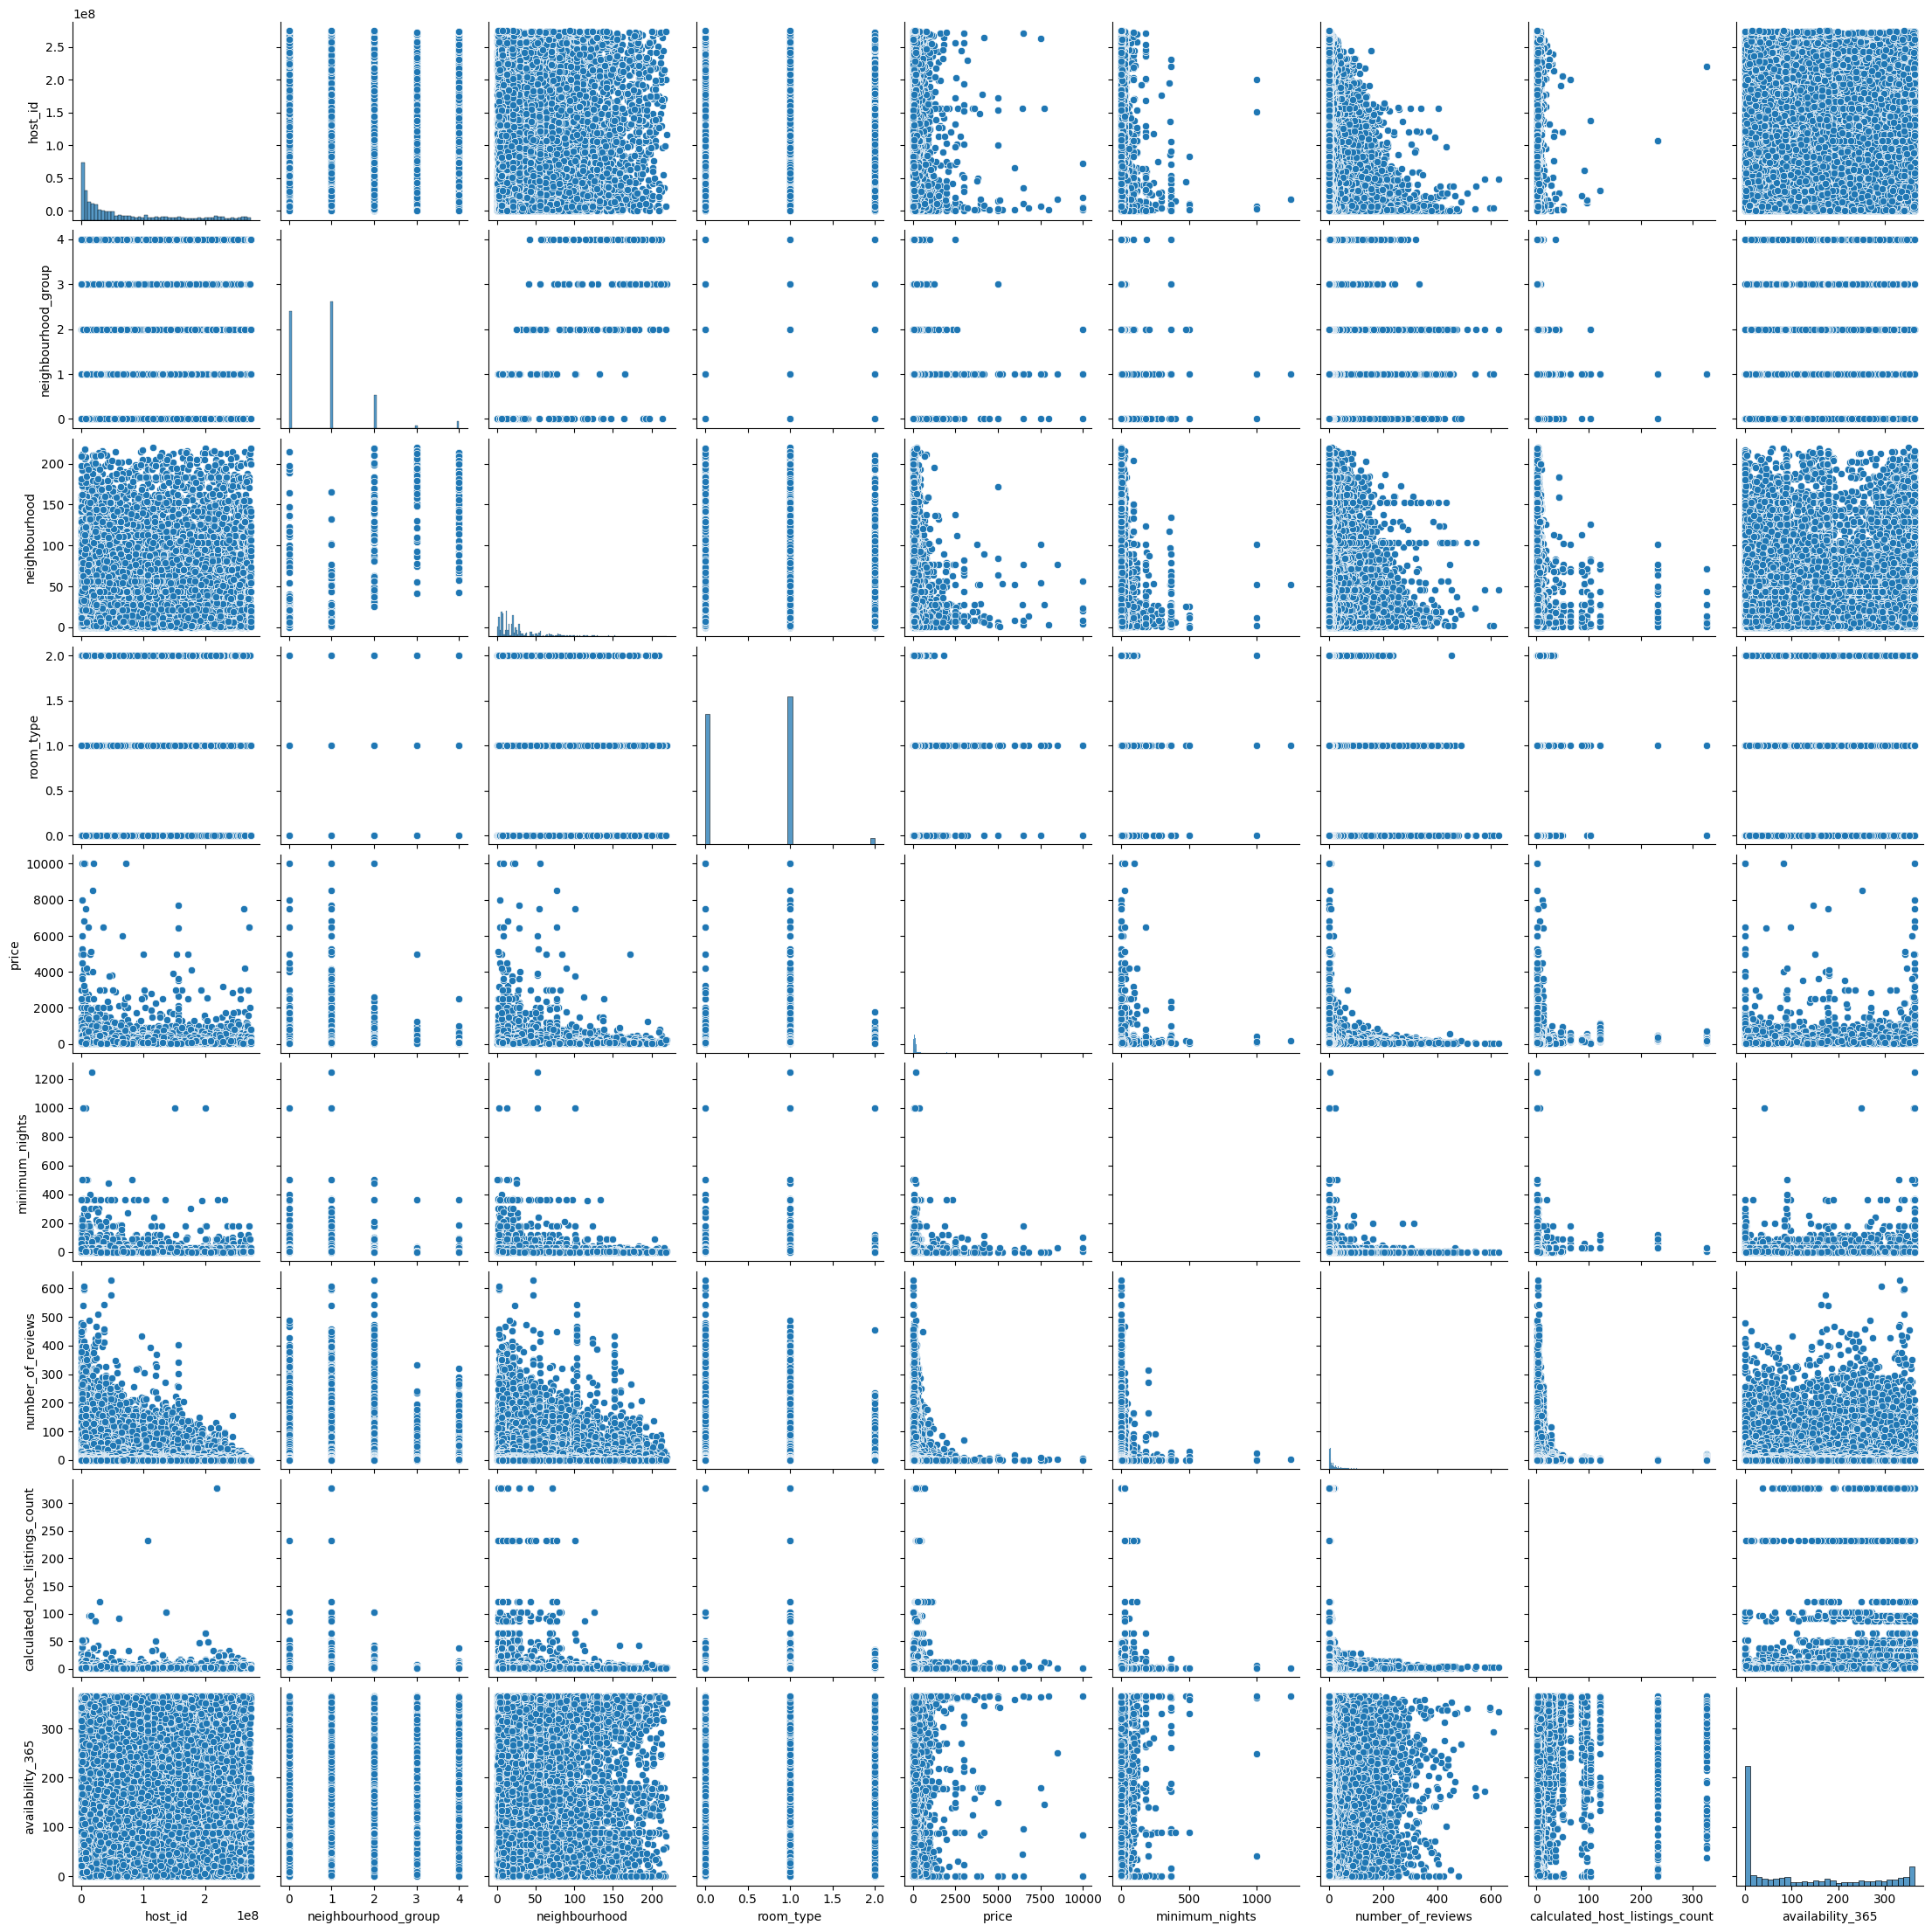

In [242]:
sns.pairplot(data = df)

#### Drop NaN Values and Name Column

In [243]:
df = df.dropna(subset=['name'])
df.drop(columns='name', inplace=True)

#### Feature Engineering

In [244]:
stats = df.describe()
stats

,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,4.882500e+04,48825.000000,48825.000000,48825.000000,48825.000000,48825.000000,48825.000000,48825.000000,48825.000000
mean,6.760583e+07,0.786769,29.874982,0.566718,152.879754,7.006718,23.287107,7.151234,112.787814
std,7.861707e+07,0.844121,34.663025,0.540717,240.272848,19.981154,44.569345,32.975488,131.619359
min,2.438000e+03,0.000000,0.000000,0.000000,20.000000,1.000000,0.000000,1.000000,0.000000
25%,7.809712e+06,0.000000,7.000000,0.000000,69.000000,1.000000,1.000000,1.000000,0.000000
50%,3.075116e+07,1.000000,19.000000,1.000000,107.000000,3.000000,5.000000,1.000000,45.000000
75%,1.074344e+08,1.000000,37.000000,1.000000,175.000000,5.000000,24.000000,2.000000,227.000000
max,2.743213e+08,4.000000,220.000000,2.000000,10000.000000,1250.000000,629.000000,327.000000,365.000000


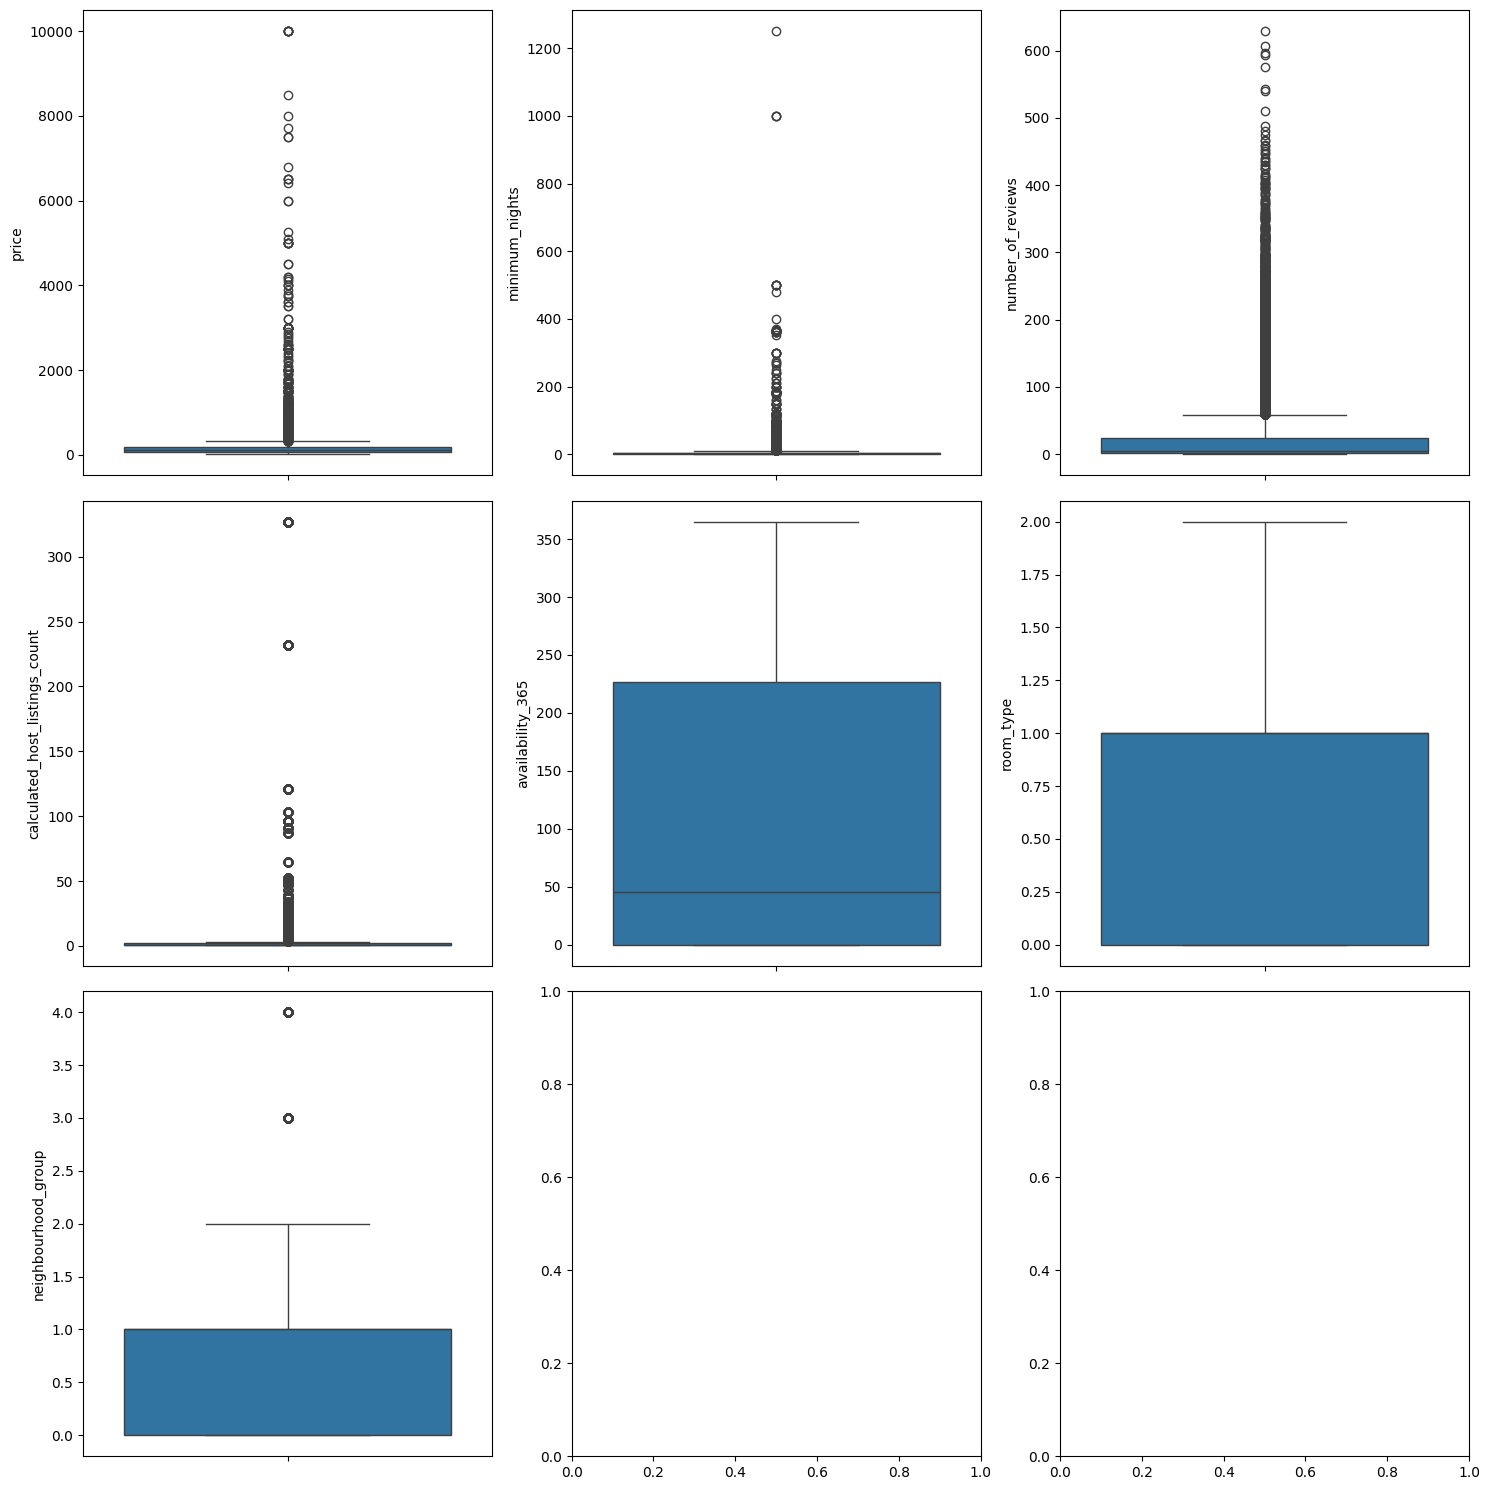

In [245]:
fig, axis = plt.subplots(3, 3, figsize=(15,15))

sns.boxplot(ax = axis[0, 0], data = df, y = "price")
sns.boxplot(ax = axis[0, 1], data = df, y = "minimum_nights")
sns.boxplot(ax = axis[0, 2], data = df, y = "number_of_reviews")
sns.boxplot(ax = axis[1, 0], data = df, y = "calculated_host_listings_count")
sns.boxplot(ax = axis[1, 1], data = df, y = "availability_365")
sns.boxplot(ax = axis[1, 2], data = df, y = "room_type")
sns.boxplot(ax = axis[2, 0], data = df, y = "neighbourhood_group")

plt.tight_layout()

plt.show()

,host_id,minimum_nights,availability_365
1305,2798644,370,365
5767,17550546,1250,365
7355,3680008,500,90
8014,10720264,500,362
10829,43945071,480,365
11193,8996336,500,365
13404,2697686,999,42
14285,2228137,500,358
15946,16476167,366,365
26341,151084261,999,249


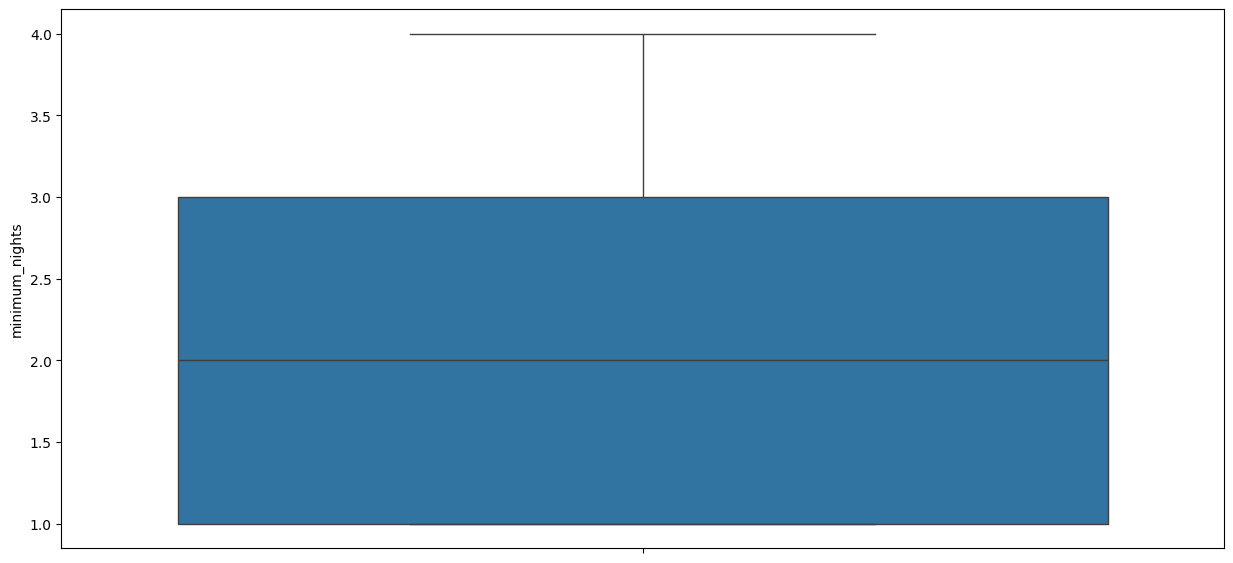

In [246]:
fig, axis = plt.subplots(figsize=(15,7))

sns.boxplot(data = df[df['minimum_nights'] < stats['minimum_nights']['75%']], y = "minimum_nights")

df[['host_id', 'minimum_nights']][df['minimum_nights'] > stats['minimum_nights']['75%']].shape
df[['host_id', 'minimum_nights']][df['minimum_nights'] > (365)].shape
df[['host_id', 'minimum_nights', 'availability_365']][(df['minimum_nights'] > 365) & (df['availability_365'] > 0)]

In [247]:
columns_for_stats = {
    'price': {
        'IQR': 0,
        'IQR - Lower Limit': 0,
        'IQR - Upper Limit': 0,
        'title': 'Price',
    }, 
    'minimum_nights': {
        'IQR': 0,
        'IQR - Lower Limit': 0,
        'IQR - Upper Limit': 0,
        'title': 'Minimum Nights',
    }, 
    'number_of_reviews': {
        'IQR': 0,
        'IQR - Lower Limit': 0,
        'IQR - Upper Limit': 0,
        'title': 'Number of Reviews',
    }, 
    'calculated_host_listings_count': {
        'IQR': 0,
        'IQR - Lower Limit': 0,
        'IQR - Upper Limit': 0,
        'title': 'Calculated Host Listings Count',
    }, 
    'availability_365': {
        'IQR': 0,
        'IQR - Lower Limit': 0,
        'IQR - Upper Limit': 0,
        'title': 'Availability 365',
    },
}

In [248]:
for k in columns_for_stats:
    columns_for_stats[k]['IQR'] = stats[k]['75%'] - stats[k]['25%']
    columns_for_stats[k]['IQR - Lower Limit'] = stats[k]["75%"] + 1.5 * columns_for_stats[k]['IQR']
    columns_for_stats[k]['IQR - Upper Limit'] = stats[k]["25%"] - 1.5 * columns_for_stats[k]['IQR']

In [249]:
for stat_col in columns_for_stats:
    print(columns_for_stats[stat_col]['title'])
    print('|-> IQR:', columns_for_stats[stat_col]['IQR'])
    print('|-> IQR - Lower Limit:', columns_for_stats[stat_col]['IQR - Lower Limit'])
    print('|-> IQR - Upper Limit:', columns_for_stats[stat_col]['IQR - Upper Limit'])
    print('\n')

Price
|-> IQR: 106.0
|-> IQR - Lower Limit: 334.0
|-> IQR - Upper Limit: -90.0


Minimum Nights
|-> IQR: 4.0
|-> IQR - Lower Limit: 11.0
|-> IQR - Upper Limit: -5.0


Number of Reviews
|-> IQR: 23.0
|-> IQR - Lower Limit: 58.5
|-> IQR - Upper Limit: -33.5


Calculated Host Listings Count
|-> IQR: 1.0
|-> IQR - Lower Limit: 3.5
|-> IQR - Upper Limit: -0.5


Availability 365
|-> IQR: 227.0
|-> IQR - Lower Limit: 567.5
|-> IQR - Upper Limit: -340.5




<hr>

#### Dropped columns and rows

1. **Dropped columns that don't have significance for the analysis:**
    * id
    * host_name
    * latitude 
    * longitude
    * last_review
    * reviews_per_month
&nbsp;
2. **Dropped records that have a price lower than 20 USD (Marked them as outliers):**
    ``` 
    df.drop(
        df[
            df['price'] < 20
        ].index, 
        inplace=True
    )
    ```
3. **Substracted information to a subset where every record has a 0 in availability_365**
    * Dropped all 'useless' columns from the subset 
        * host_id
        * neighbourhood_group
        * neighbourhood
        * latitude
        * longitude
        * calculated_host_listings_count
4. **Dropped rows where name is null (Undone)**
    ```
    df = df.dropna(
        subset=['name']
    )
    ```

5. **Columns to drop outliers**
    * price - **Done** ```df.drop(df[df['price'] < 20].index, inplace=True)```
    * minimum_nights - **Undone** ```df.drop(df[(df['minimum_nights']>365) & (df['availability_365'] > 364)].index, inplace=True)```
    * number_of_reviews - **Done**
    * calculated_host_listings_count - **Done**
    * availability_365 - **Done**

6. **Drop nulls in name column and dropped name column**
    ```
    df = df.dropna(
        subset=['name']
    )
    ```
    ```
    df.drop(
        columns='name', 
        inplace=True
    )
    ```
**In my opinion the only outliers in the dataset are the prices lower than 20 USD, I don't consider the rest of the numbers to be outliers because from the bussiness point of view the numbers that seem higher or lower than "normal" may be resonable according to the functions and capabilities that the app actually has and the uses a person can think of from a tenant/client perspective.**

#### Feature Scaling

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48825 entries, 0 to 48894
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   host_id                         48825 non-null  int64
 1   neighbourhood_group             48825 non-null  int64
 2   neighbourhood                   48825 non-null  int64
 3   room_type                       48825 non-null  int64
 4   price                           48825 non-null  int64
 5   minimum_nights                  48825 non-null  int64
 6   number_of_reviews               48825 non-null  int64
 7   calculated_host_listings_count  48825 non-null  int64
 8   availability_365                48825 non-null  int64
dtypes: int64(9)
memory usage: 3.7 MB


In [251]:
# numericals = [
#     "number_of_reviews", 
#     "minimum_nights", 
#     "calculated_host_listings_count", 
#     "availability_365", 
#     "neighbourhood_group", 
#     "room_type"
# ]
numericals = [
    "number_of_reviews", 
    "minimum_nights", 
    "calculated_host_listings_count", 
    "neighbourhood_group", 
    "room_type"
]

In [265]:
scaler = MinMaxScaler()
features = scaler.fit_transform(df[numericals])
print(features[1])

df_scal = pd.DataFrame(features, index = df.index, columns = numericals)

print(df.shape)

df_scal['price'] = df['price']
df_scal['availability_365'] = df['availability_365']

print(df.shape)
df_scal.head()

[0.07154213 0.         0.00306748 0.25       0.5       ]
(48825, 9)
(48825, 9)


,number_of_reviews,minimum_nights,calculated_host_listings_count,neighbourhood_group,room_type,price,availability_365
0,0.014308,0.000000,0.015337,0.00,0.0,149,365
1,0.071542,0.000000,0.003067,0.25,0.5,225,355
2,0.000000,0.001601,0.000000,0.25,0.0,150,365
3,0.429253,0.000000,0.000000,0.00,0.5,89,194
4,0.014308,0.007206,0.000000,0.25,0.5,80,0


#### Feature Selection
Select the top 4 features for the SelectKBest object, I think that the most impact on the availability prediction might from at least 4 of the 5 columns I have in the df_scal dataframe, I'm not really sure if number_of_reviews impacts the availability or if it is the other way around.

In [267]:
x = df_scal.drop('availability_365', axis=1)
y = df_scal['availability_365']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

model = SelectKBest(chi2, k=4)
model.fit(x_train, y_train)

x_train_sel = pd.DataFrame(model.transform(x_train), columns = x_train.columns.values[model.get_support()])
x_test_sel = pd.DataFrame(model.transform(x_test), columns = x_test.columns.values[model.get_support()])

x_train_sel.head()


,number_of_reviews,calculated_host_listings_count,neighbourhood_group,price
0,0.116057,0.00000,0.25,78.0
1,0.011129,0.00000,0.25,128.0
2,0.006359,0.00000,0.00,90.0
3,0.144674,0.00000,0.25,89.0
4,0.036566,0.01227,1.00,65.0


#### Save the Data

In [268]:
x_train_sel["price"] = list(y_train)
x_test_sel["price"] = list(y_test)

df.to_csv("../data/processed/clean_AB_NYC_2019.csv")
room_0_av.to_csv("../data/processed/availability_0_subset.csv")

x_train_sel.to_csv("../data/processed/clean_train.csv", index = False)
x_test_sel.to_csv("../data/processed/clean_test.csv", index = False)